In [1]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 2.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_recall_fscore_support, classification_report, confusion_matrix, ConfusionMatrixDisplay

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler

from torchvision import transforms

import timm
import itertools
import os

from tqdm import tqdm
from collections import Counter
from PIL import Image

import cv2

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
WFH = False

In [5]:
if not WFH:
  from google.colab import drive
  drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
drive_path = ""
if not WFH:
  # Change as required
  drive_path = "/Data Pipeline/Datasets/Original Images/"

In [7]:
train_df = pd.read_csv(drive_path + 'Clean_train.csv', encoding='latin-1')
val_df = pd.read_csv(drive_path + 'Clean_val.csv', encoding='latin-1')
test_df = pd.read_csv(drive_path + 'Clean_test.csv', encoding='latin-1')

In [8]:
classes = ["Tooth_marked", "Cracks", "Coating"]

In [9]:
train_labels = train_df[classes].values
val_labels = val_df[classes].values
test_labels = test_df[classes].values

In [10]:
transform = transforms.Compose([
  transforms.RandomResizedCrop(224, scale=(0.2, 1.0), interpolation=3),  # 3 is bicubic
  transforms.RandomHorizontalFlip(),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]
)

In [11]:
class CustomDataset(Dataset):
    def __init__(self, img_dir, img_names, labels, transform=None):
        self.img_dir = img_dir
        self.labels = labels
        self.transform = transform
        self.img_names = img_names

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_name = self.img_names[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
          image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.float32)

In [12]:
train_folder_path = drive_path + 'Train'
train_image_files = os.listdir(train_folder_path)

val_folder_path = drive_path + 'Val'
val_image_files = os.listdir(val_folder_path)

test_folder_path = drive_path + 'Test'
test_image_files = os.listdir(test_folder_path)

In [13]:
print(len(train_image_files) == len(train_labels))
print(len(val_image_files) == len(val_labels))
print(len(test_image_files) == len(test_labels))

True
True
True


In [14]:
train_dataset = CustomDataset(img_dir=train_folder_path, img_names=train_image_files, labels=train_labels, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=16)

In [15]:
val_dataset = CustomDataset(img_dir=val_folder_path, img_names=val_image_files, labels=val_labels, transform=transform)
val_dataloader = DataLoader(val_dataset, batch_size=16)

In [16]:
test_dataset = CustomDataset(img_dir=test_folder_path, img_names=test_image_files, labels=test_labels, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=16)

# Model Training

In [17]:
num_classes = len(train_labels[0])

In [18]:
class CustomSEResNeXt_v2(nn.Module):
    def __init__(self, num_classes=3, dropout_p=0.25):
        super(CustomSEResNeXt_v2, self).__init__()

        self.model = timm.create_model('seresnext50_32x4d', pretrained=True)

        # Freeze all parameters
        for param in self.model.parameters():
            param.requires_grad = False

        # Unfreeze the final bottleneck block
        for param in self.model.layer4.parameters():
            param.requires_grad = True

        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, 512)
        self.dropout1 = nn.Dropout(dropout_p)
        self.hidden = nn.Linear(512, 128)
        self.dropout2 = nn.Dropout(dropout_p)
        self.fc_pred = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.model(x)
        x = F.relu(self.hidden(self.dropout1(x)))
        x = self.fc_pred(self.dropout2(x))
        return x

In [19]:
model = CustomSEResNeXt_v2()
model

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/111M [00:00<?, ?B/s]

CustomSEResNeXt_v2(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act2): ReLU(inplace=True)
        (aa): Identity()
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchN

In [20]:
model.to(device)

CustomSEResNeXt_v2(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act2): ReLU(inplace=True)
        (aa): Identity()
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchN

In [21]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0005)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=10, verbose=True)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [22]:
num_epochs = 15
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        predictions = model(images)
        loss = criterion(predictions, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}')

    # Validation Phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(val_dataloader, desc="Validation", unit="batch", leave=False):
            images, labels = images.to(device), labels.to(device)

            predictions = model(images)
            loss = criterion(predictions, labels)
            val_loss += loss.item() * images.size(0)

    epoch_val_loss = val_loss / len(val_dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {epoch_val_loss:.4f}')

    scheduler.step(epoch_val_loss)

    # Save the model if it has the best validation loss so far
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        print("Model saved!")

print('Finished Training')

Epoch 1/15: 100%|██████████| 14/14 [00:11<00:00,  1.21batch/s]


Epoch [1/15], Train Loss: 0.6986


Epoch [1/15], Validation Loss: 0.6882
Model saved!


Epoch 2/15: 100%|██████████| 14/14 [00:05<00:00,  2.71batch/s]


Epoch [2/15], Train Loss: 0.6671


Epoch [2/15], Validation Loss: 0.7012


Epoch 3/15: 100%|██████████| 14/14 [00:04<00:00,  3.29batch/s]


Epoch [3/15], Train Loss: 0.6705


Epoch [3/15], Validation Loss: 0.6906


Epoch 4/15: 100%|██████████| 14/14 [00:04<00:00,  3.28batch/s]


Epoch [4/15], Train Loss: 0.6421


Epoch [4/15], Validation Loss: 0.6652
Model saved!


Epoch 5/15: 100%|██████████| 14/14 [00:05<00:00,  2.56batch/s]


Epoch [5/15], Train Loss: 0.6315


Epoch [5/15], Validation Loss: 0.7394


Epoch 6/15: 100%|██████████| 14/14 [00:04<00:00,  3.33batch/s]


Epoch [6/15], Train Loss: 0.6005


Epoch [6/15], Validation Loss: 0.7267


Epoch 7/15: 100%|██████████| 14/14 [00:04<00:00,  3.04batch/s]


Epoch [7/15], Train Loss: 0.5575


Epoch [7/15], Validation Loss: 0.7663


Epoch 8/15: 100%|██████████| 14/14 [00:04<00:00,  2.88batch/s]


Epoch [8/15], Train Loss: 0.5296


Epoch [8/15], Validation Loss: 0.7240


Epoch 9/15: 100%|██████████| 14/14 [00:04<00:00,  3.24batch/s]


Epoch [9/15], Train Loss: 0.4886


Epoch [9/15], Validation Loss: 0.8518


Epoch 10/15: 100%|██████████| 14/14 [00:04<00:00,  2.82batch/s]


Epoch [10/15], Train Loss: 0.4377


Epoch [10/15], Validation Loss: 1.0627


Epoch 11/15: 100%|██████████| 14/14 [00:05<00:00,  2.75batch/s]


Epoch [11/15], Train Loss: 0.3652


Epoch [11/15], Validation Loss: 0.8632


Epoch 12/15: 100%|██████████| 14/14 [00:04<00:00,  3.28batch/s]


Epoch [12/15], Train Loss: 0.3434


Epoch [12/15], Validation Loss: 1.3364


Epoch 13/15: 100%|██████████| 14/14 [00:05<00:00,  2.72batch/s]


Epoch [13/15], Train Loss: 0.3352


Epoch [13/15], Validation Loss: 1.1480


Epoch 14/15: 100%|██████████| 14/14 [00:04<00:00,  3.22batch/s]


Epoch [14/15], Train Loss: 0.2930


Epoch [14/15], Validation Loss: 1.2137


Epoch 15/15: 100%|██████████| 14/14 [00:04<00:00,  3.02batch/s]


Epoch [15/15], Train Loss: 0.2185


Epoch [15/15], Validation Loss: 1.3280
Finished Training


In [23]:
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

CustomSEResNeXt_v2(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act2): ReLU(inplace=True)
        (aa): Identity()
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchN

# Thresholding

In [24]:
train_predictions = []
sigmoid = nn.Sigmoid()

for image in tqdm(train_df['Image']):
    img_path = os.path.join(train_folder_path, image)
    img = Image.open(img_path).convert('RGB')
    img = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        pred = model(img)
    train_predictions.append(sigmoid(pred).cpu().numpy())

tooth_mark_probs = [output[:, 0] for output in train_predictions]
cracks_probs = [output[:, 1] for output in train_predictions]
coating_probs = [output[:, 2] for output in train_predictions]

100%|██████████| 218/218 [00:07<00:00, 30.66it/s]


In [25]:
df_probs = pd.DataFrame({
    'Tooth_marked': list(itertools.chain(*tooth_mark_probs)),
    'Cracks': list(itertools.chain(*cracks_probs)),
    'Coating': list(itertools.chain(*coating_probs))
})

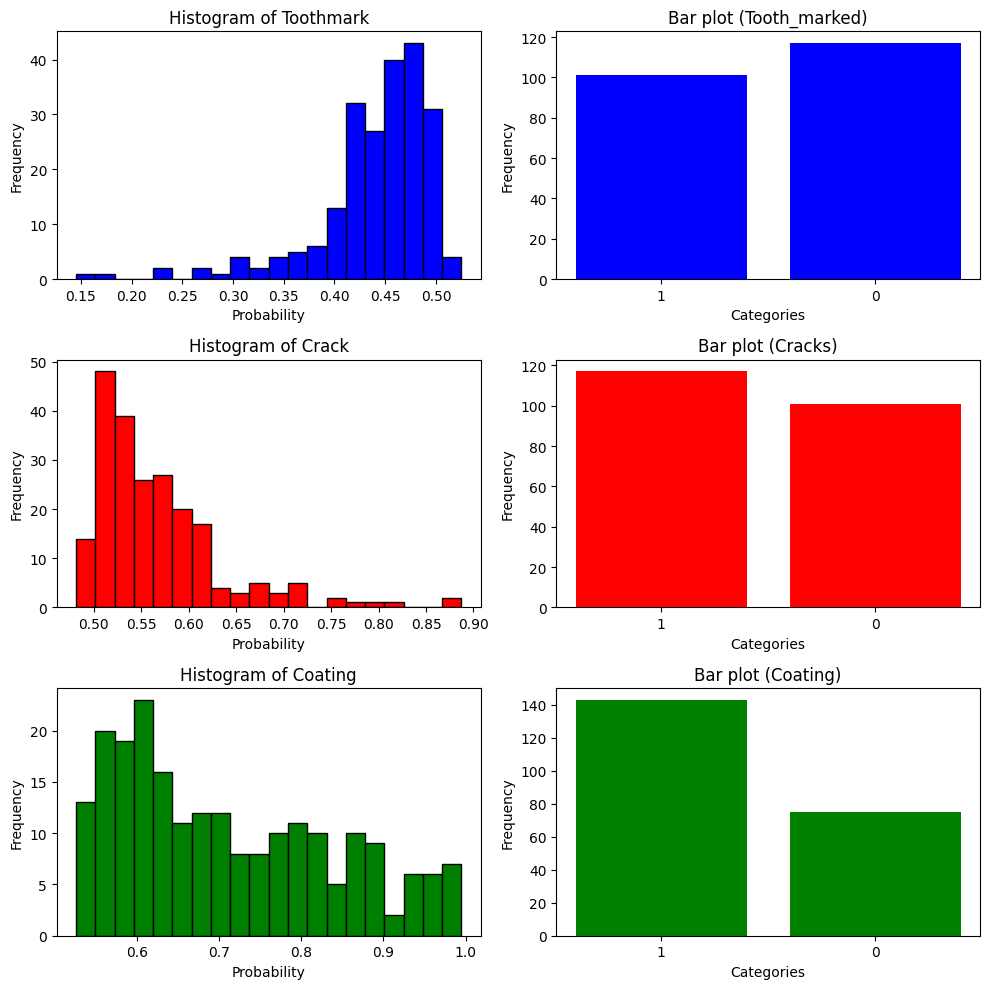

In [26]:
colors = ["blue","red","green"]
feature_list = ["Toothmark","Crack","Coating"]
fig, axes = plt.subplots(3, 2, figsize=(10, 10))

for i in range(len(feature_list)):
    axes[i,0].hist(df_probs.iloc[:, i], bins=20,edgecolor = "black",color = colors[i])
    axes[i,0].set_xlabel('Probability')
    axes[i,0].set_ylabel('Frequency')
    axes[i,0].set_title(f'Histogram of {feature_list[i]}')

    axes[i,1].bar(["1","0"], [np.sum(train_df.iloc[:, i+1]),len(train_df) - np.sum(train_df.iloc[:, i+1])], color = colors[i])
    axes[i,1].set_xlabel('Categories')
    axes[i,1].set_ylabel('Frequency')
    axes[i,1].set_title(f'Bar plot ({train_df.columns[i+1]})')

plt.tight_layout()

In [27]:
def find_optimal_thresholds(probs, groundtruths, labels):
  optimal_thresholds = {}
  for i, label in enumerate(labels):
    label_probs = probs[:, i]
    label_groundtruth = groundtruths[:, i]

    best_threshold = 0.0
    best_f1 = -1.0

    for threshold in np.arange(0.01, 1.01, 0.001):
      binary_predictions = (label_probs >= threshold).astype(int)
      f1 = f1_score(label_groundtruth, binary_predictions)

      if f1 > best_f1:
        best_threshold = threshold
        best_f1 = f1

    optimal_thresholds[label] = {
        "threshold": round(best_threshold, 2),
        "f1_score": best_f1
    }

  return optimal_thresholds

In [28]:
toothmark_prob = df_probs["Tooth_marked"].values
toothmark_groundtruth = np.array(train_df['Tooth_marked'])
crack_prob = df_probs["Cracks"].values
crack_groundtruth = np.array(train_df['Cracks'])
coating_prob = df_probs["Coating"].values
coating_groundtruth = np.array(train_df['Coating'])

probs = np.stack((toothmark_prob, crack_prob, coating_prob), axis=1)
groundtruths = np.stack((toothmark_groundtruth, crack_groundtruth, coating_groundtruth), axis=1)
labels = ["Tooth_marked", "Cracks", "Coating"]

optimal_thresholds = find_optimal_thresholds(probs, groundtruths, labels)

for label, values in optimal_thresholds.items():
  print(f"Label: {label}")
  print(f"Optimal Threshold: {values['threshold']}")
  print(f"F1 Score: {values['f1_score']}")
  print()

Label: Tooth_marked
Optimal Threshold: 0.37
F1 Score: 0.6531986531986531

Label: Cracks
Optimal Threshold: 0.51
F1 Score: 0.7032258064516129

Label: Coating
Optimal Threshold: 0.58
F1 Score: 0.8136645962732918



In [29]:
thresholds = [v['threshold'] for _, v in optimal_thresholds.items()]

# Evaluation Utilities

In [30]:
def evaluate_model(model, dataloader, criterion, device, thresholds, class_names):
    model.eval()
    running_loss = 0.0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Evaluating", unit="batch"):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)

            sigmoid_outputs = torch.sigmoid(outputs).cpu().numpy()
            preds = np.zeros_like(sigmoid_outputs)
            for i, threshold in enumerate(thresholds):
                preds[:, i] = sigmoid_outputs[:, i] > threshold

            all_predictions.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    avg_loss = running_loss / len(dataloader.dataset)

    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)

    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='macro')
    report = classification_report(all_labels, all_predictions, target_names=class_names)

    for i, class_name in enumerate(class_names):
        cm = confusion_matrix(all_labels[:, i], all_predictions[:, i])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f'Not {class_name}', class_name])
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f'Confusion Matrix - {class_name}')
        plt.show()

    return all_predictions, all_labels, avg_loss, precision, recall, f1, report

# Validation

Evaluating: 100%|██████████| 2/2 [00:00<00:00,  3.20batch/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


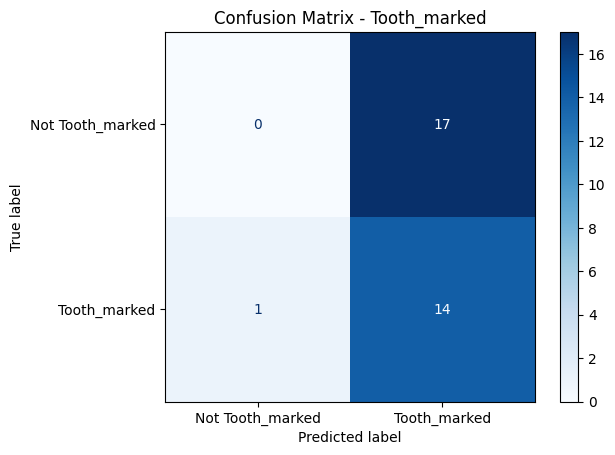

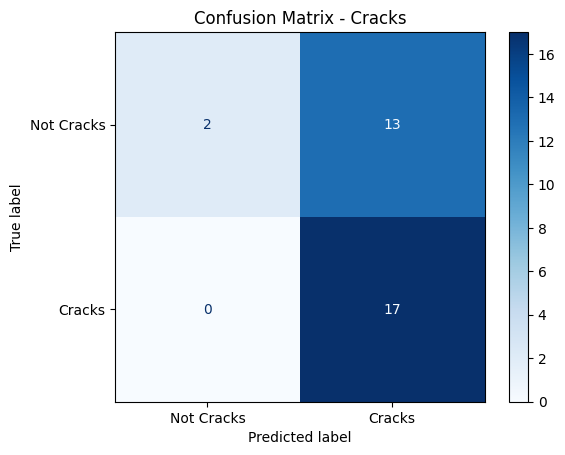

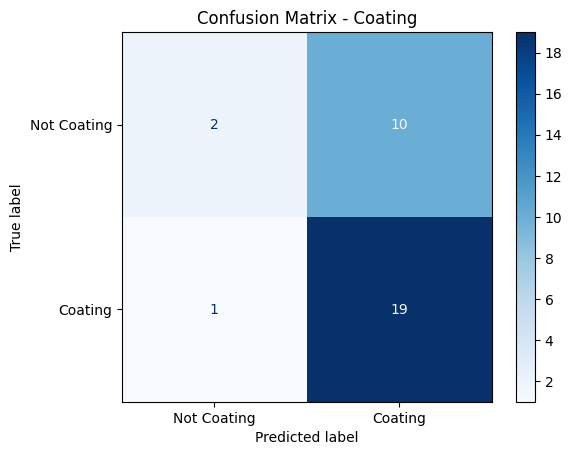

In [31]:
val_preds, val_labels, val_loss, val_precision, val_recall, val_f1, val_report = evaluate_model(model, val_dataloader, criterion, device, thresholds, class_names=classes)

In [32]:
print(f'Validation Loss: {val_loss:.4f}')
print(f'Validation Precision: {val_precision:.4f}')
print(f'Validation Recall: {val_recall:.4f}')
print(f'Validation F1-score: {val_f1:.4f}')
print(f'Classification Report:\n{val_report}')

Validation Loss: 0.6632
Validation Precision: 0.5578
Validation Recall: 0.9611
Validation F1-score: 0.7025
Classification Report:
              precision    recall  f1-score   support

Tooth_marked       0.45      0.93      0.61        15
      Cracks       0.57      1.00      0.72        17
     Coating       0.66      0.95      0.78        20

   micro avg       0.56      0.96      0.70        52
   macro avg       0.56      0.96      0.70        52
weighted avg       0.57      0.96      0.71        52
 samples avg       0.55      0.86      0.65        52



# Testing

Evaluating: 100%|██████████| 4/4 [00:38<00:00,  9.74s/batch]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


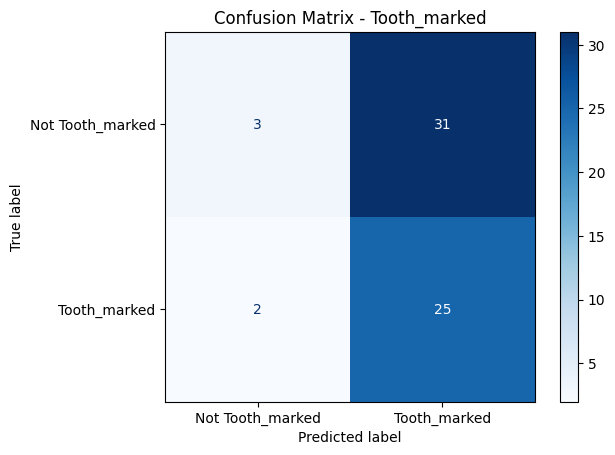

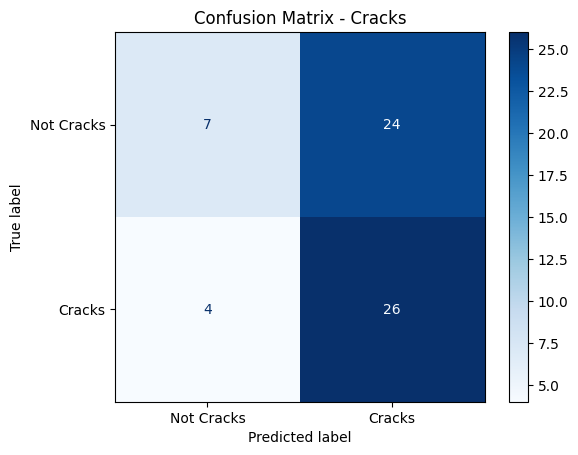

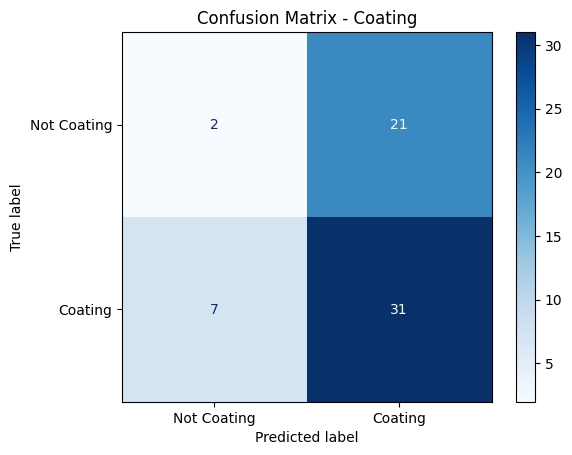

In [33]:
test_preds, test_labels, test_loss, test_precision, test_recall, test_f1, test_report = evaluate_model(model, test_dataloader, criterion, device, thresholds, class_names=classes)

In [34]:
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')
print(f'Test F1-score: {test_f1:.4f}')
print(f'Classification Report:\n{test_report}')

Test Loss: 0.6958
Test Precision: 0.5209
Test Recall: 0.8695
Test F1-score: 0.6471
Classification Report:
              precision    recall  f1-score   support

Tooth_marked       0.45      0.93      0.60        27
      Cracks       0.52      0.87      0.65        30
     Coating       0.60      0.82      0.69        38

   micro avg       0.52      0.86      0.65        95
   macro avg       0.52      0.87      0.65        95
weighted avg       0.53      0.86      0.65        95
 samples avg       0.51      0.77      0.58        95

